## 第十周: 字詞分類
+ 課程目標
    + 用字詞向量的方式將不同的文集分類
+ 資料來源:
    + gutenberg 網站的兩本英文小說
    + 「pride and prejudice」 of Jane austen
    + 「the war of the worlds」 of H. G. Wells
+ 分析流程
    1. 文字前處理
        + 1-1 斷句
        + 1-2 前處理：斷詞（刪掉次數太少的、標點符號、停用字）
        + 1-3 算出情緒分數，將正負面文章分類
        + 1-4 將情緒標籤加回原本的資料集
    2. 將資料分為測試集和訓練集
        + 根據7:3的比例切分資料集
    3. 將文章轉為 DTM 放入模型訓練
        + 3-1 簡單範例介紹DTM
        + 3-2 套入正式資料集訓練
    4. 比較不同模型和資料組合的訓練結果
        + 資料集: 詞頻、tfidf 的 DTM
        + 比較標準: ROC, AUC, confusion matrix
        + 模型:
            + 4-1 logistic regression
            + 4-2 SVC
            + 4-3 decision tree
        + 4-4 預測結果探索

In [1]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import time

In [2]:
books = pd.read_csv("data/books.csv") #匯資料
books.head(3)

,gutenberg_id,text,title,document
0,36,The War of the Worlds,The War of the Worlds,1
1,36,NaN,The War of the Worlds,2
2,36,by H. G. Wells [1898],The War of the Worlds,3


一個句子視為一個document，查看兩本書各有多少個句子

In [3]:
books.title.value_counts()

Pride and Prejudice      13030
The War of the Worlds     6474
Name: title, dtype: int64

## 1. 文字前處理
+ 進行斷詞
+ 去除stopwords
+ 篩選出現太少次的字

定義停用字

In [4]:
nltk.download('stopwords')
user_defined_stop_words = ['st','rd','hong','kong'] 

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

[nltk_data] Downloading package stopwords to /home/ann2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())   # 去除標點符號
    x = [w for w in x.split() if w not in set(stopwords)]  # 去除停用字
    return x

斷詞、去除標點符號、去除停用字

In [6]:
data = books[books['text'].notnull()] # 去掉 nan 的 row
data['text'] = data['text'].apply(preprocess) # 資料前處理
data = data.explode('text')
data.head(5)

/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,gutenberg_id,text,title,document
0,36,war,The War of the Worlds,1
0,36,worlds,The War of the Worlds,1
2,36,h,The War of the Worlds,3
2,36,g,The War of the Worlds,3
2,36,wells,The War of the Worlds,3


去除掉詞頻小於10的字

In [7]:
occur = 10
filtered = data.groupby(['gutenberg_id','text'])['text'].filter(lambda x: len(x) >= occur) # 出現次數大於10的字
data = data[data['text'].isin(filtered)]
data

,gutenberg_id,text,title,document
0,36,war,The War of the Worlds,1
5,36,shall,The War of the Worlds,6
7,36,world,The War of the Worlds,8
7,36,things,The War of the Worlds,8
7,36,made,The War of the Worlds,8
...,...,...,...,...
19502,1342,towards,Pride and Prejudice,19503
19502,1342,persons,Pride and Prejudice,19503
19502,1342,bringing,Pride and Prejudice,19503
19503,1342,derbyshire,Pride and Prejudice,19504


### 資料集基本檢視

看資料集裡面有幾個字

In [8]:
print(f"unique words: {len(data.text.unique())}")

unique words: 1428


詞性還原

In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
data['lemma'] = data['text'].apply(lambda x: lemmatizer.lemmatize(x))

In [10]:
print(f"words reducing after lemma: {len(data.text.unique()) - len(data.lemma.unique())}")

words reducing after lemma: 94


看兩本書的常用的20個字

In [11]:
# 算兩本書的字頻
word_count = (data
             .groupby(['gutenberg_id','lemma'], as_index=False).size()
             .sort_values(by=['gutenberg_id','size'], ascending=False))
word_count.head(5)

,gutenberg_id,lemma,size
1779,1342,mr,1126
1402,1342,elizabeth,632
1303,1342,could,524
2252,1342,would,469
1992,1342,said,401


In [12]:
# 選出兩本書詞頻最高的20個字
top_n = 20
book1 = word_count[word_count["gutenberg_id"]==36].head(top_n).sort_values(by=['size']) # The War of the Worlds 
book2 = word_count[word_count["gutenberg_id"]==1342].head(top_n).sort_values(by=['size']) # pride and prejudice
book1.head(5)

,gutenberg_id,lemma,size
777,36,road,101
629,36,night,101
577,36,men,103
116,36,brother,103
217,36,day,104


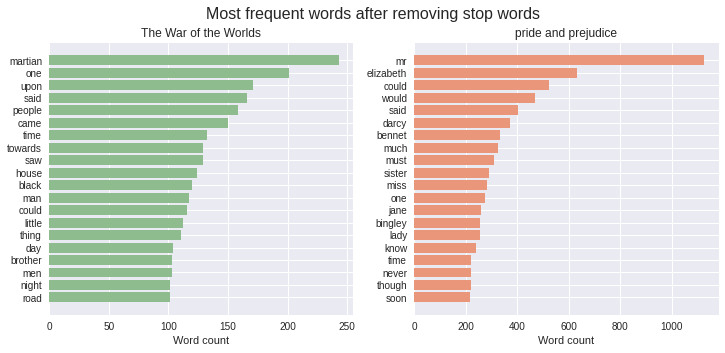

In [13]:
plt.figure(figsize=(12,5))   
plt.style.use('seaborn')    

# The War of the Worlds
plt.subplot(121)
plt.title('The War of the Worlds')
plt.xlabel('Word count')
plt.barh(book1['lemma'],book1['size'],color="darkseagreen")

# pride and prejudice
plt.subplot(122)
plt.title('pride and prejudice')
plt.xlabel('Word count')
plt.barh(book2['lemma'],book2['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('Most frequent words after removing stop words', fontsize=16)

plt.show()

可以看到世界大戰(The War of the Worlds)出現的詞比較不特定，如「people」、「time」、「men」等；傲慢與偏見(pride and prejudice)則比較常出現主要角色的名字或人物稱謂，如「elizabeth」、「jane」、「mr」、「sister」，其他字詞的風格也非常不一樣。

In [14]:
nltk.download('stopwords')
user_defined_stop_words = ['st','rd','hong','kong'] 

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

[nltk_data] Downloading package stopwords to /home/ann2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def preprocess(x):  
    x = re.sub('[^a-z\s]', '', x.lower())   # 去除標點符號
    x = [w for w in x.split() if w not in set(stopwords)]  # 去除停用字
    return " ".join(x)

In [16]:
raw_data = books[books['text'].notnull()].reset_index() # 去掉 nan 的 row
original = raw_data # 用來看原本句子長什麼樣的
raw_data['text'] = raw_data['text'].apply(preprocess) # 資料前處理
raw_data.head(5)

,index,gutenberg_id,text,title,document
0,0,36,war worlds,The War of the Worlds,1
1,2,36,h g wells,The War of the Worlds,3
2,5,36,shall dwell worlds,The War of the Worlds,6
3,6,36,inhabited lords,The War of the Worlds,7
4,7,36,world things made man,The War of the Worlds,8


### 2. 將資料切成訓練集與測試集
+ 根據7:3的比例切分資料集

把整個資料集七三切

In [17]:
dtf_train, dtf_test = model_selection.train_test_split(raw_data, stratify=raw_data["gutenberg_id"],
                                                       test_size=0.3, random_state=2021)

## get target
y_train = dtf_train["gutenberg_id"].values
y_test = dtf_test["gutenberg_id"].values

In [18]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{raw_data['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['gutenberg_id'].value_counts(normalize=True) * 100}")

raw data percentage :
1342    66.322301
36      33.677699
Name: gutenberg_id, dtype: float64

train percentage :
1342    66.319046
36      33.680954
Name: gutenberg_id, dtype: float64

test percentage :
1342    66.329897
36      33.670103
Name: gutenberg_id, dtype: float64


### 3. 將文章轉為 DTM
+ 3-1 簡單的例子示範
+ 3-2 套入正式的資料集

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字
    + min_df: 篩選出現次數大於10的字(可以自行定義要不要篩選，可能會造成準確度下降)
    + ngram_range: unigrams and bigrams

### 3-1 簡單範例介紹DTM

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = ['why hello there', 'omg hello hello pony', 'she went there? omg']
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

# 轉成dataframe來看
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

print(f"documents: {X.shape[0]} terms: {X.shape[1]}")
print(f"\nterms:\n {vocabulary}") # DTM 字詞可以藉由 get_feature_names 查看
print(f"\nDTM array:\n {X.toarray()}") # DTM的資料結構，裡面代表字詞的頻率
DTM_df

documents: 3 terms: 15

terms:
 ['hello', 'hello hello', 'hello pony', 'hello there', 'omg', 'omg hello', 'pony', 'she', 'she went', 'there', 'there omg', 'went', 'went there', 'why', 'why hello']

DTM array:
 [[1 0 0 1 0 0 0 0 0 1 0 0 0 1 1]
 [2 1 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 1 1 1 1 0 0]]


,hello,hello hello,hello pony,hello there,omg,omg hello,pony,she,she went,there,there omg,went,went there,why,why hello
0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1
1,2,1,1,0,1,1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,1,1,1,1,1,0,0


### 3-2 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [20]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2)) 
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2),
                                                            min_df = 10)
# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100, ngram_range=(1,2))

+ 過濾詞頻比較

In [21]:
corpus = dtf_train["text"]

# 沒過濾詞頻
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 詞頻> 10
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

In [22]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 

without term cut off: posts 11315 words: 10000 (10000)
with term cut off: posts 11315 words: 1257 (1257)


定義分類器模型

In [23]:
classifier = LogisticRegression()

定義模型訓練組合

In [24]:
## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.91
Auc: 0.97
Detail:
              precision    recall  f1-score   support

          36       0.92      0.80      0.86      1633
        1342       0.91      0.96      0.93      3217

    accuracy                           0.91      4850
   macro avg       0.91      0.88      0.90      4850
weighted avg       0.91      0.91      0.91      4850



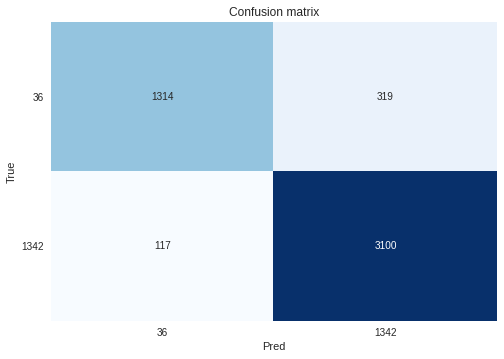

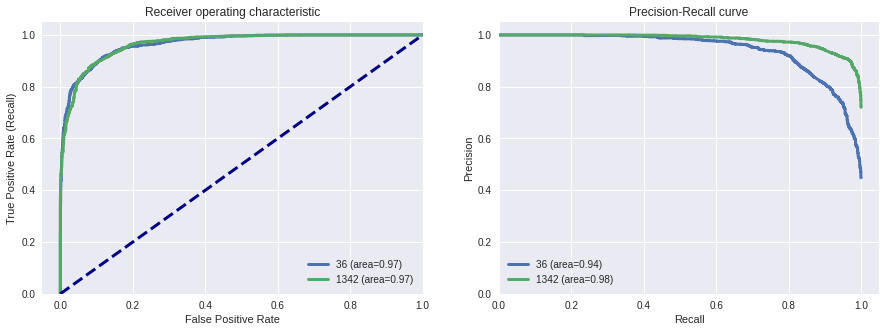

In [25]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 2. 將資料切成訓練集與測試集
+ 根據7:3的比例切分資料集

In [26]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(raw_data, 
                                                       stratify=raw_data["gutenberg_id"],
                                                       test_size=0.3, random_state=2021)

In [27]:
## get target
y_train = dtf_train["gutenberg_id"].values
y_test = dtf_test["gutenberg_id"].values

In [28]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{raw_data['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['gutenberg_id'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['gutenberg_id'].value_counts(normalize=True) * 100}")

raw data percentage :
1342    66.322301
36      33.677699
Name: gutenberg_id, dtype: float64

train percentage :
1342    66.319046
36      33.680954
Name: gutenberg_id, dtype: float64

test percentage :
1342    66.329897
36      33.670103
Name: gutenberg_id, dtype: float64


In [29]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [30]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

### step 1 定義 vectorizer

In [31]:
cut_off = 10 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off) 
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df = cut_off)

### step 2 定義 classifier

In [32]:
cla_lg = LogisticRegression()
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [33]:
train_data = dtf_train["text"]
test_data = dtf_test["text"]
train_label = y_train
test_label = y_test

In [34]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 4-2-1 Model Building : logistic regression

model type: CV + logistic regression
2
time costing: 0.29775452613830566
Accuracy: 0.87
Auc: 0.95
Detail:
              precision    recall  f1-score   support

          36       0.85      0.75      0.80      1633
        1342       0.88      0.93      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



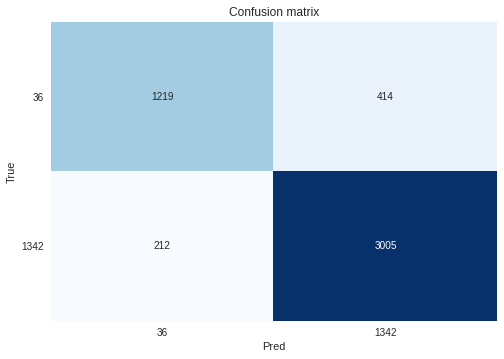

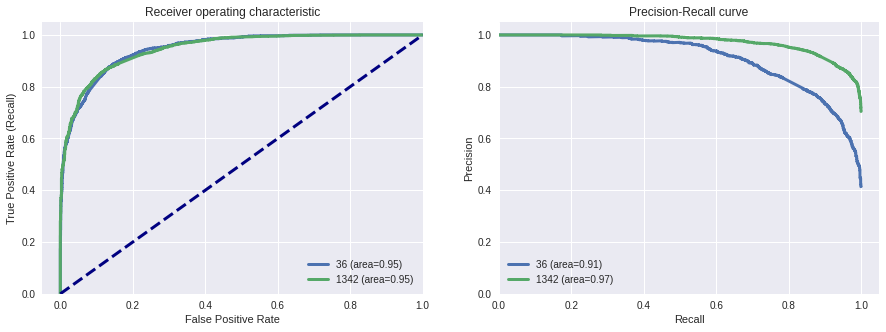

In [36]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(train_data, test_data, train_label,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression
2
time costing: 0.2889578342437744
Accuracy: 0.87
Auc: 0.94
Detail:
              precision    recall  f1-score   support

          36       0.88      0.73      0.80      1633
        1342       0.87      0.95      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.88      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



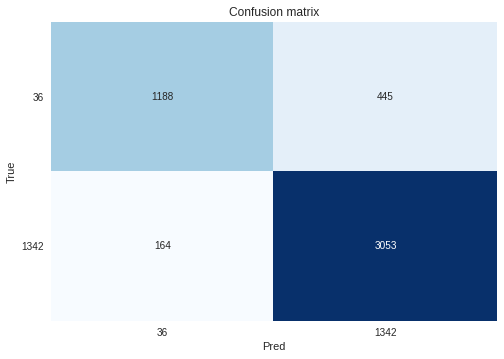

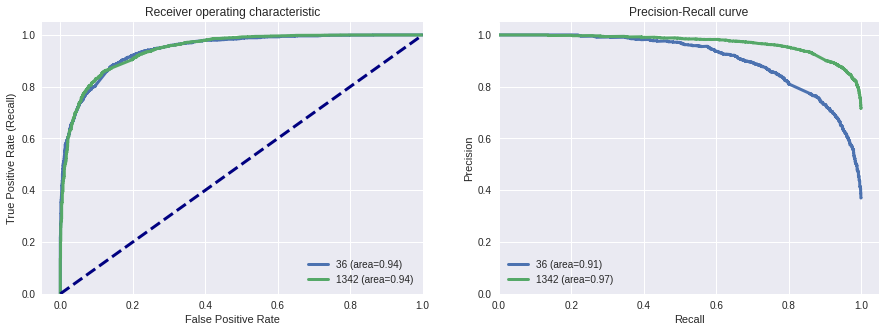

In [37]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4-2-2 Model Building : SVC

model type: CV + SVC
2
time costing: 19.512634754180908
Accuracy: 0.87
Auc: 0.94
Detail:
              precision    recall  f1-score   support

          36       0.87      0.73      0.79      1633
        1342       0.87      0.94      0.91      3217

    accuracy                           0.87      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.87      0.87      4850



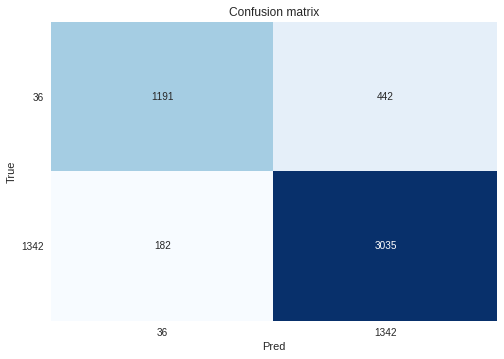

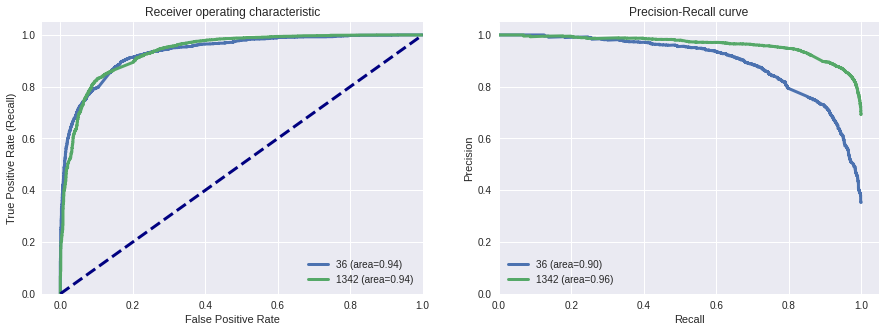

In [38]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
2
time costing: 18.853140830993652
Accuracy: 0.88
Auc: 0.92
Detail:
              precision    recall  f1-score   support

          36       0.87      0.74      0.80      1633
        1342       0.88      0.94      0.91      3217

    accuracy                           0.88      4850
   macro avg       0.87      0.84      0.85      4850
weighted avg       0.87      0.88      0.87      4850



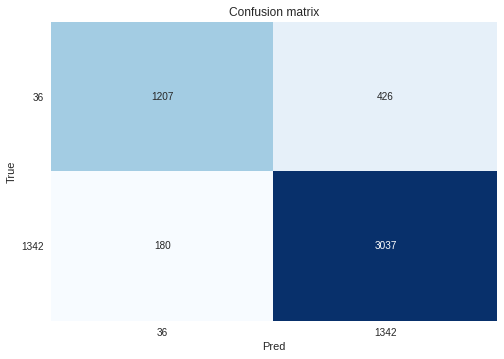

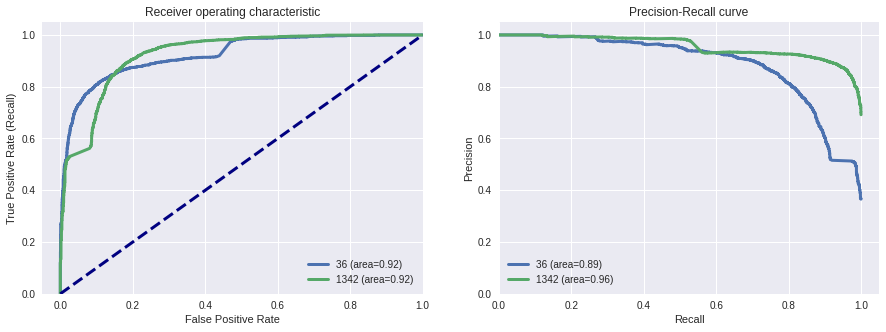

In [39]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4-2-3 Model Building : RandomForest

model type: CV + RandomForest
2
time costing: 3.9317750930786133
Accuracy: 0.83
Auc: 0.91
Detail:
              precision    recall  f1-score   support

          36       0.73      0.77      0.75      1633
        1342       0.88      0.86      0.87      3217

    accuracy                           0.83      4850
   macro avg       0.81      0.82      0.81      4850
weighted avg       0.83      0.83      0.83      4850



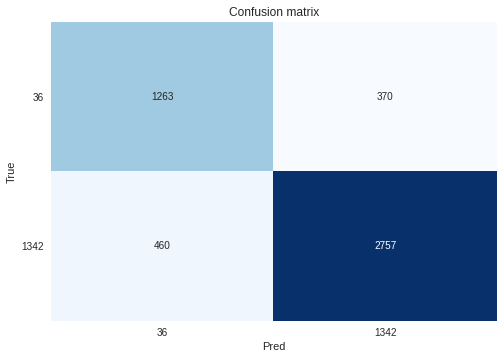

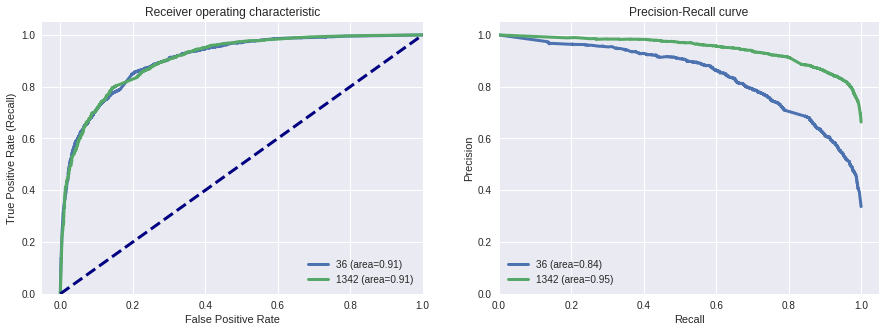

In [40]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
2
time costing: 4.687798976898193
Accuracy: 0.85
Auc: 0.92
Detail:
              precision    recall  f1-score   support

          36       0.81      0.74      0.77      1633
        1342       0.87      0.91      0.89      3217

    accuracy                           0.85      4850
   macro avg       0.84      0.83      0.83      4850
weighted avg       0.85      0.85      0.85      4850



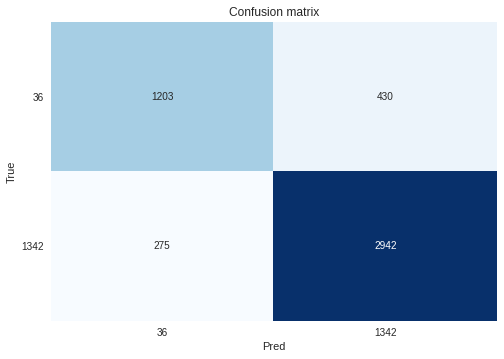

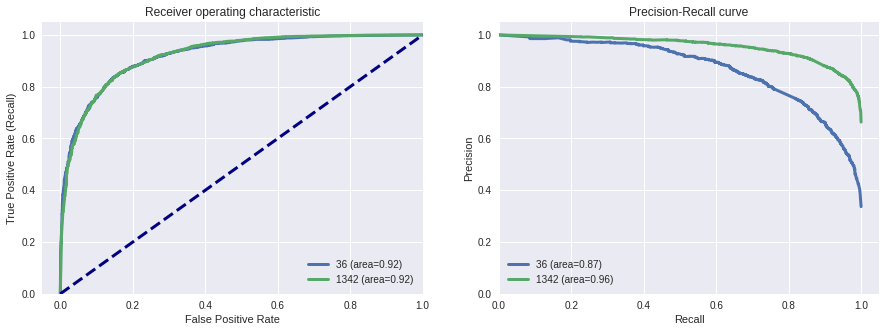

In [41]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 4-4 預測結果探索
+ 4-4-1 各字詞特徵的estimate係數
+ 4-4-2 查看分類錯誤的句子
+ 4-4-3 比較不同模型的ROC

In [42]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
3,TF-IDF + SVC,0.875052,0.923489
1,TF-IDF + logistic regression,0.874433,0.944018
2,CV + SVC,0.871340,0.936056
0,CV + logistic regression,0.870928,0.946421
5,TF-IDF + RandomForest,0.854639,0.921809
4,CV + RandomForest,0.828866,0.906083


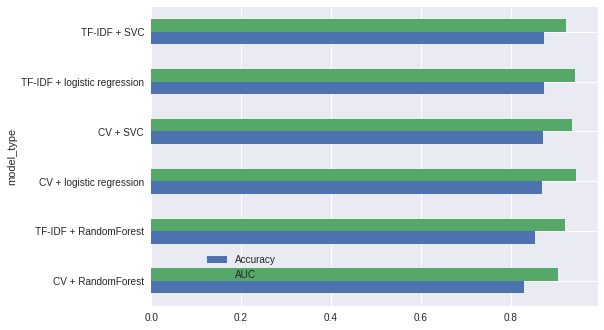

In [43]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(0.3,0.2))

### 4-4-1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 4-2-1 的 logistic regression + cv tokenizer 為例

In [44]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 5)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 設定中文
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [45]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 4-2-1 存起來的模型
log_odds = logisticRegr.coef_[0]
coef_df = pd.DataFrame(log_odds,
             vocabulary, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coef_df.head(5)

,coef
elizabeth,5.468591
mr,4.508444
jane,3.472826
darcy,3.465086
mrs,3.094937


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


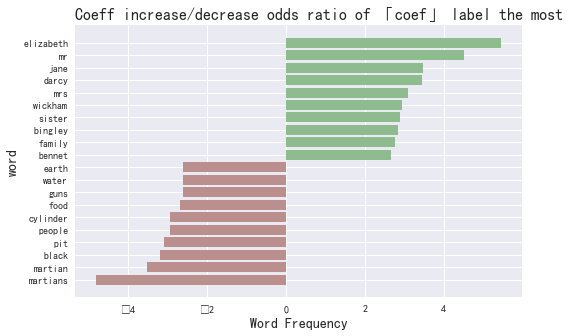

In [46]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

elizabeth,sister,family 等字是影響判斷為傲慢與偏見的重要字；gun,pit,food等字是影響判斷是戰爭與和平(不是傲慢與偏見)的重要字

### 看一下含特定關鍵字的句子

In [47]:
keyword_list = ['food','gun']
original[original['text'].str.contains('|'.join(keyword_list),regex=True)][['gutenberg_id','text']].head(3)

,gutenberg_id,text
35,36,surface must begun course fact scarcely one
94,36,think blaze may casting huge gun
107,36,flaming gases rushed gun


### 4-4-2 查看分類錯誤的句子

這邊用4-4-1 logistic + cv 的模型當例子

In [48]:
# original # 原本的句子
d = {'true': y_test, 'predict': pred_l}
result = pd.DataFrame(data=d)

# 0: the war of the worlds
# 1: pride and prejudice
# False negative: pride and prejudice(true) => the war of the worlds(prediction)
# False positive: the war of the worlds(true) => pride and prejudice(prediction)
dtf_test['predict'] = pred_l
book1_wrong = dtf_test.loc[(dtf_test['gutenberg_id'] == 36) & (dtf_test['predict'] == 1342)] # False negative
book2_wrong = dtf_test.loc[(dtf_test['gutenberg_id'] == 1342) & (dtf_test['predict'] == 36)] # False positive

print(f"False negative:{book1_wrong.shape}")
print(f"False positive:{book2_wrong.shape}")

False negative:(414, 6)
False positive:(212, 6)


/usr/local/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [49]:
# False negative
book1_wrong[['text','document','gutenberg_id','predict']].head(5)

,text,document,gutenberg_id,predict
552,sunset faded twilight anything happened,668,36,1342
3965,gesticulating moment shared panic gesture,4738,36,1342
4193,crawl drink craved eleventh day,5006,36,1342
182,earthward rushing pace many miles second,214,36,1342
102,twelfth spectroscope resorted,124,36,1342


In [50]:
# False positive:
book2_wrong[['text','document','gutenberg_id','predict']].head(5)

,text,document,gutenberg_id,predict
9973,one,12021,1342,36
15665,case,18893,1342,36
12327,brought time descent among hanging woods,14840,1342,36
11027,near relationship constant intimacy still one,13281,1342,36
12254,suddenly came forward road led behind stables,14760,1342,36


### 4-4-3 比較不同模型的ROC

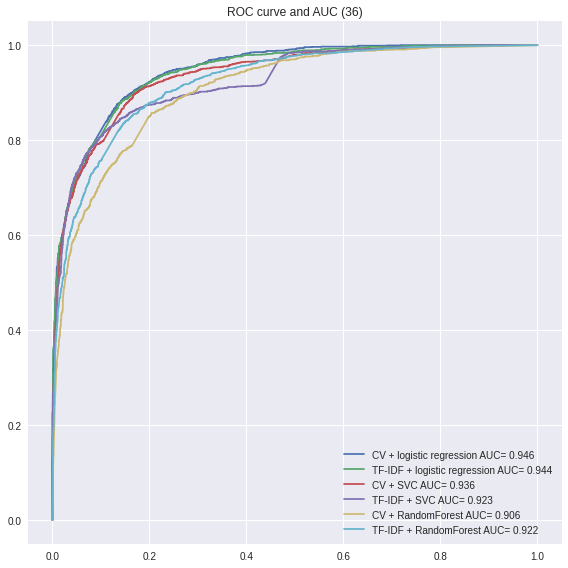

In [51]:
plt.style.use('seaborn')    

l = [36]
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ str(label) +')')    
    plt.legend(loc=0)
    plt.tight_layout() # 讓圖片對齊

accuracy可能會因為正負面資料分布不同而有所偏差，所以選擇模型的時候，可以加入一起 AUC 評估。在這裡可以看到雖然 SVC+TF-IDF的準確度是最高的，但以AUC來看，CV + logistic的 AUC 反而表現較好。

### 參考資料

+ DTM
+ https://theslaps.medium.com/constructing-a-document-term-matrix-via-sklearn-nltk-65de053d9e91
+ Logistic Regression using Python (scikit-learn)
+ https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
+ Advantages of AUC vs standard accuracy
+ https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy